In [48]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', 100)
import seaborn as sns
import scipy

import warnings
warnings.filterwarnings("ignore")

In [49]:
# verinin okunması : 

data = pd.read_csv("train.csv")
df = data.copy()
# df.info()

In [50]:
# sayısal veri içerdikleri için numerik gözüken değişkenlerin tipini kategorik tipine (object) çevrilmesi : 

df.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']] = df.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']].astype('object')

In [51]:
## ikinci bölümde yapsak daha iyi olacağını düşünüyorum ?

# for col in df.columns :
#     if df[col].dtype == 'object' :
#         df[col] = df[col].astype('category')

<AxesSubplot:>

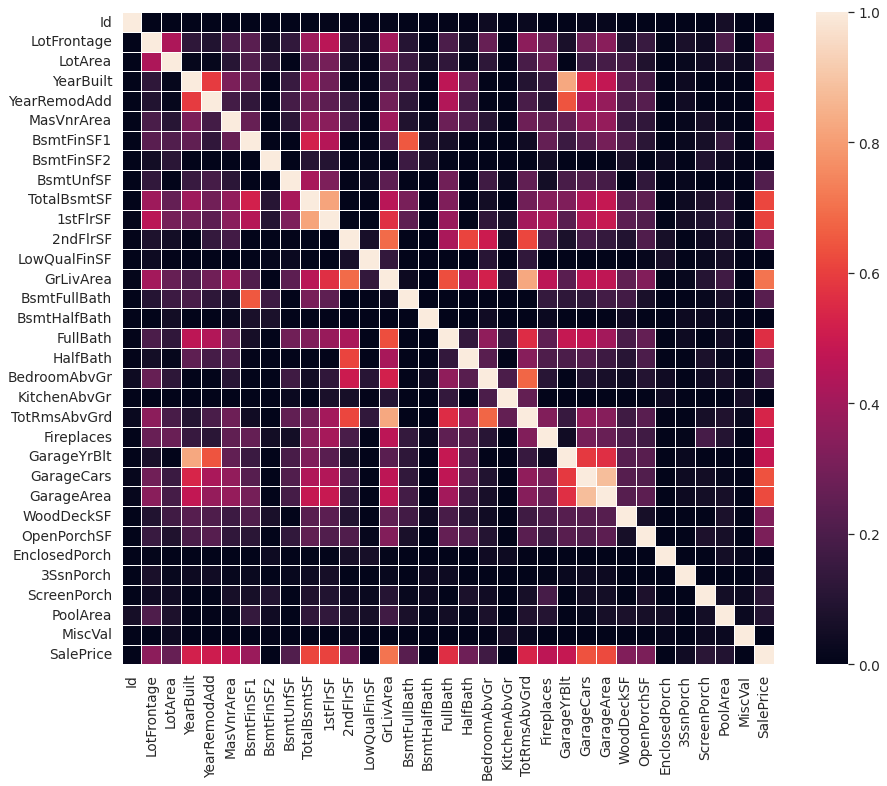

In [52]:
# numerik değişkenler arasındaki korelasyonlara hızlı bir bakış : 

corr = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr,linewidths=.5, vmin=0, vmax=1, square=True)

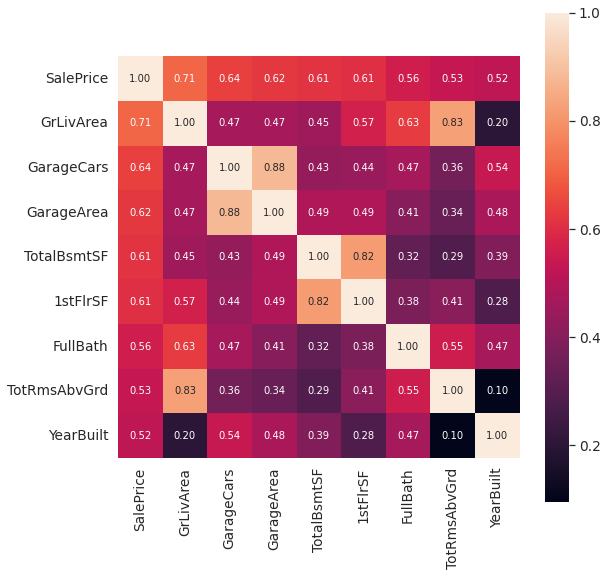

In [53]:
# saleprice korelasyon matrisi:

k = 9 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [54]:
# yüzdesel olarak eksik verilerin kontrolü: 

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [55]:
# kolonlardaki 0'ların yüzdesel olarak gösterimi: 

total = (df == 0).sum(axis=0).sort_values(ascending=False)
percent = ((df == 0).sum(axis=0)/df.count()).sort_values(ascending=False)
zeros = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
zeros.head(8)

,Total,Percent
PoolArea,1453,0.995205
3SsnPorch,1436,0.983562
LowQualFinSF,1434,0.982192
MiscVal,1408,0.964384
BsmtHalfBath,1378,0.943836
ScreenPorch,1344,0.920548
BsmtFinSF2,1293,0.885616
EnclosedPorch,1252,0.857534


### Edinilen bu bilgiler ışığında, "PoolQC","MiscFeature","Alley","Fence" ve "FireplaceQu" değişkenleri :

### 1- yüzdesel olarak fazlaca eksik değere sahip olduğu için 
### 2- saleprice değişkenini çok fazla etkilemeyeceği düşünüldüğü için

### Veri setinden çıkarılmasına karar verilmiştir. 


In [56]:
# veri setinden çıkarılacak değişkenlerin çıkarılması: 

df=df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1)

In [57]:
# numerik ve kategorik olan kolonları ayrı değişkenlere atanması:

num_col=df._get_numeric_data().columns.tolist()
cat_col=set(df.columns)-set(num_col)

In [58]:
# incelememiz gereken diğer değişkenleri görmek için tekrar eksik veri tablosunun gösterimi:

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342


## Feature Engineering Bölümü

Lot frontage ile ilgili bir iki bilgi yaz

In [11]:
# lot frontage

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

Bath ile ilgili bir iki bilgi yaz

In [12]:
# bathX 

df['TotalBath'] = df['FullBath'] + (0.5*df['HalfBath']) + df['BsmtFullBath'] + (0.5*df['BsmtHalfBath'])
df = df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis = 1)


df['GarageCond']
GarageX ile ilgili açıklamalar yapılacak ve tekrar gözden geçirilmesi gerek

In [13]:
# garageX
# bu değişkenler arasından çıkarmayalım dedikleriniz olursa konuşalım.
df = df.drop(['GarageArea','GarageYrBlt','GarageCond','GarageFinish'], axis = 1)

df['GarageType'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)

BasementX ile ilgili açıklamalar yapılacak ve tekrar gözden geçirilmesi gerek

In [14]:
# basementX
df = df.drop(['BsmtFinSF2','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1','BsmtFinType2','BsmtFinType1'], axis = 1)

df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)

## bu kolonlarıda çıkardım? 
# df['BsmtFinType2'].fillna('NA', inplace=True)
# df['BsmtFinType1'].fillna('NA', inplace=True)

Conditionla ilgili yaz

In [15]:
#Condition kolonlarının düzenlenmesi:

df[["Condition1","Condition2", "SalePrice"]].head(100)

,Condition1,Condition2,SalePrice
0,Norm,Norm,208500
1,Feedr,Norm,181500
2,Norm,Norm,223500
3,Norm,Norm,140000
4,Norm,Norm,250000
...,...,...,...
95,Norm,Norm,185000
96,Norm,Norm,214000
97,Norm,Norm,94750
98,Norm,Norm,83000


In [16]:
# condition1

df["Condition1"].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [17]:
# condition2

df["Condition2"].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [18]:
# condition2 değişkeni çıkarıldı, condition1 değişkeninin adı "condition" olarak değiştirildi:

df.drop("Condition2", axis=1, inplace=True)
df.rename(columns={"Condition1": "Condition"}, inplace=True)


In [19]:
# masvnr
# bu değişken için farklı bir şey yapılacak. 

# df["MasVnrType"].fillna('NA', inplace=True)
# df["MasVnrType"].replace('None', 'NA',inplace=True)

In [20]:
# electrical :

df = df.drop(df.loc[df['Electrical'].isnull()].index)

In [21]:
# 1stFlrSF ve 2ndFlrSF değişkenlerinin toplamı GrLivArea değişkenini verdiği için bu iki değişken veri setinden çıkarıldı: 

#1. kat alanı ve 2. kat alanı GrLivArea'yı verdiği için iki kolon da silindi.
df.drop(["1stFlrSF","2ndFlrSF"], axis=1, inplace=True)

In [23]:
## 0'lar var, ne yapabiliriz?

df["TotalPorch"] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df = df.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], axis = 1)


In [60]:
# son olarak bol sıfırlı ve ilişkisinin düşük olacağını düşündüğümüz kolonları da veri setimizden çıkartıyoruz:
# doğru değişkenleri mi uçurmuşum? 
df = df.drop(['PoolArea','LowQualFinSF','MiscVal'], axis = 1)


In [61]:
# veri setinin son hali : 

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,61,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,298,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,42,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,35,272,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,192,84,0,0,0,12,2008,WD,Normal,250000
